In [22]:
import numpy as np
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# **User Inputs (Scaled down from the macroscopic dimensions, so G is taken as 1)**

In [23]:
G=1
m1=(float)(input("Enter the mass of planet 1:"))
m2=(float)(input("Enter the mass of planet 2:"))
x1_0=(float)(input("Enter x coordinate of planet 1:"))
y1_0=(float)(input("Enter y coordinate of planet 1:"))
x2_0=(float)(input("Enter x coordinate of planet 2:"))
y2_0=(float)(input("Enter y coordinate of planet 2:"))
r1_0=np.array([x_1,y_1])
r2_0=np.array([x_2,y_2])
v1x0=(float)(input("Enter the x component of velocity vector of planet 1:"))
v1y0=(float)(input("Enter the y component of velocity vector of planet 1:"))
v2x0=(float)(input("Enter the x component of velocity vector of planet 2:"))
v2y0=(float)(input("Enter the y component of velocity vector of planet 2:"))
v1_0=np.array([v1xx,v1yy])
v2_0=np.array([v2xx,v2yy])
t=(float)(input("Enter the time of prediction of position:"))

Enter the mass of planet 1: 1
Enter the mass of planet 2: 1
Enter x coordinate of planet 1: 1
Enter y coordinate of planet 1: 0
Enter x coordinate of planet 2: -1
Enter y coordinate of planet 2: 0
Enter the x component of velocity vector of planet 1: 0
Enter the y component of velocity vector of planet 1: 0.5
Enter the x component of velocity vector of planet 2: 0
Enter the y component of velocity vector of planet 2: -0.5
Enter the time of prediction of position: 10


1
1.0
1.0
[1. 0.]
[-1.  0.]
[0.  0.5]
[ 0.  -0.5]
10.0


# **Two Body ODE function(Data Set Generation)**

In [24]:
initial_state=np.concatenate((r1_0,v1_0,r2_0,v2_0))
def two_body_ode(t,state):
    x1,y1,v1x,v1y,x2,y2,v2x,v2y=state
    delta=np.array([x2-x1,y2-y1])
    r=np.linalg.norm(delta)
    if r==0:
        print("The position of both the planets are the same")
        return
    a1=(G*delta*m2)/r**3
    a2=-(G*delta*m1)/r**3
    return [v1x,v1y,a1[0],a1[1],v2x,v2y,a2[0],a2[1]]

t_interval=(0,t*2)
t_data=np.linspace(*t_interval,1000)
#finds the solution to the second order differential equation
phy_data=solve_ivp(two_body_ode,t_interval,initial_state,t_eval=t_data)
body1_x,body1_y=phy_data.y[0],phy_data.y[1]
body2_x,body2_y=phy_data.y[4],phy_data.y[5]
body1_vx,body1_vy=phy_data.y[2],phy_data.y[3]
body2_vx,body2_vy=phy_data.y[6],phy_data.y[7]
states=sol.y.T
derivatives=np.array([two_body_ode(t,y) for t,y in zip(t_data,states)])
a1=derivatives[:,2:4]
a2=derivatives[:,6:8]

noise_level=(float)(input("enter the noise level:"))
print(noise_level)

body1_x_true=torch.tensor(body1_x,dtype=torch.float32).view(-1,1)
body1_y_true=torch.tensor(body1_y,dtype=torch.float32).view(-1,1)
body2_x_true=torch.tensor(body2_x,dtype=torch.float32).view(-1,1)
body2_y_true=torch.tensor(body2_y,dtype=torch.float32).view(-1,1)
pos_true=torch.cat([body1_x_true,body1_y_true,body2_x_true,body2_y_true],dim=1)

noise=torch.tensor(noise_level*np.random.randn(1000),dtype=torch.float32).view(-1,1)
body1_x_noise=body1_x_true+noise
body1_y_noise=body1_y_true+noise
body2_x_noise=body2_x_true+noise
body2_y_noise=body2_y_true+noise
pos_noise=torch.cat([body1_x_noise,body1_y_noise,body2_x_noise,body2_y_noise],dim=1)
t_tensor=torch.tensor(t_data,dtype=torch.float32).view(-1,1)

v1x_tensor=torch.tensor(body1_vx,dtype=torch.float32).view(-1,1)
v1y_tensor=torch.tensor(body1_vy,dtype=torch.float32).view(-1,1)
v2x_tensor=torch.tensor(body2_vx,dtype=torch.float32).view(-1,1)
v2y_tensor=torch.tensor(body2_vy,dtype=torch.float32).view(-1,1)
v_tensor=torch.cat([v1x_tensor,v1y_tensor,v2x_tensor,v2y_tensor],dim=1)

a1_tensor=torch.tensor(a1,dtype=torch.float32).view(-1,2)
a2_tensor=torch.tensor(a2,dtype=torch.float32).view(-1,2)
acc_true=torch.cat([a1_tensor,a2_tensor],dim=1)


enter the noise level: 0.5


0.5


# **Train-Test Splitting**

In [35]:

train_ratio=0.8
num_samples=t_tensor.shape[0] 
num_train=int(train_ratio*num_samples)
indices=np.random.permutation(num_samples)
train_idx=indices[:num_train]
test_idx=indices[num_train:]

t_train=t_tensor[train_idx]
t_test=t_tensor[test_idx]

pos_noise_train=pos_noise[train_idx]
pos_true_train=pos_true[train_idx]

pos_noise_test=pos_noise[test_idx]
pos_true_test=pos_true[test_idx]

v_tensor_train=v_tensor[train_idx]
v_tensor_test=v_tensor[test_idx]

acc_true_train=acc_true[train_idx]
acc_true_test=acc_true[test_idx]

# **Gradients**

In [36]:
def derivative(y,t):
    first_ode=[]
    for i in range(4):
        grad=torch.autograd.grad(y[:,i],t,grad_outputs=torch.ones_like(y[:,i]),create_graph=True,retain_graph=True)[0]
        first_ode.append(grad)
    return torch.cat(first_ode,dim=1)

def double_derivative(y,t):
    second_ode=[]
    for i in range(4):
        grad=torch.autograd.grad(y[:,i],t,grad_outputs=torch.ones_like(y[:,i]),create_graph=True,retain_graph=True)[0]
        second_ode.append(grad)
    return torch.cat(second_ode,dim=1)


*# *Loss Functions**

In [37]:
#functions to include the loss between the predicted and true values then training the model accordingly
def loss(ypred,ytrue):
    return torch.mean((ypred-ytrue)**2)

def phy_loss(model,t):
    t.requires_grad_(True)
    pos_pred=model(t)
    first_ode=derivative(pos_pred,t)
    second_ode=double_derivative(first_ode,t)
    return loss(second_ode,acc_true_train)

def data_loss(model,t):
    pos_pred=model(t)
    return loss(pos_pred,pos_true_train)

# **Defining the model**

In [38]:
#building the structure of the neural network
class PINN_GM(nn.Module):
    def __init__(self):
        super(PINN_GM,self).__init__()
        self.body1_x_net=nn.Sequential(nn.Linear(1,64),nn.Tanh(),nn.Linear(64,1))
        self.body1_y_net=nn.Sequential(nn.Linear(1,64),nn.Tanh(),nn.Linear(64,1))
        self.body2_x_net=nn.Sequential(nn.Linear(1,64),nn.Tanh(),nn.Linear(64,1))
        self.body2_y_net=nn.Sequential(nn.Linear(1,64),nn.Tanh(),nn.Linear(64,1))

    def forward(self,t):
        body1_x=self.body1_x_net(t)
        body1_y=self.body1_y_net(t)
        body2_x=self.body2_x_net(t)
        body2_y=self.body2_y_net(t)
        return torch.cat([body1_x,body1_y,body2_x,body2_y],dim=1)
model=PINN_GM()


# **Training the model**

In [39]:
optimizer=torch.optim.Adam(model.parameters(),lr=0.01)
beta_phy=100
beta_data=1
num_epochs=10000
print_every=500

print('\nStarting ADAM optimisation...')
model.train()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    phyloss=phy_loss(model,t_train)
    dataloss=data_loss(model,t_train)
    total_loss=beta_phy*phyloss+beta_data*dataloss
    total_loss.backward()
    optimizer.step()

    if ((epoch+1) % print_every)==0:
        print(f"Epoch {epoch+1}/{num_epochs}",f"Total Loss={total_loss.item():.6f}",f"Physics Loss={phyloss.item():.6f}",
            f"Data Loss={dataloss.item():.6f}")

#fine-tuning the model
lbfgs_optimizer = torch.optim.LBFGS(model.parameters(), lr=1.0, max_iter=500, tolerance_grad=1e-9, tolerance_change=1e-9, history_size=50, line_search_fn='strong_wolfe')
def closure():
    lbfgs_optimizer.zero_grad()
    phyloss=phy_loss(model,t_train)
    dataloss=data_loss(model,t_train)
    total_loss=beta_phy*phyloss+beta_data*dataloss
    total_loss.backward()
    return total_loss
print("\nStarting LBFGS optimization...")
lbfgs_optimizer.step(closure)

model.eval()


Starting ADAM optimisation...
Epoch 500/10000 Total Loss=0.183373 Physics Loss=0.001639 Data Loss=0.019481
Epoch 1000/10000 Total Loss=0.022193 Physics Loss=0.000153 Data Loss=0.006926
Epoch 1500/10000 Total Loss=0.011932 Physics Loss=0.000042 Data Loss=0.007743
Epoch 2000/10000 Total Loss=0.001286 Physics Loss=0.000013 Data Loss=0.000019
Epoch 2500/10000 Total Loss=0.000821 Physics Loss=0.000008 Data Loss=0.000017
Epoch 3000/10000 Total Loss=0.001352 Physics Loss=0.000006 Data Loss=0.000720
Epoch 3500/10000 Total Loss=0.000469 Physics Loss=0.000005 Data Loss=0.000014
Epoch 4000/10000 Total Loss=0.000517 Physics Loss=0.000004 Data Loss=0.000138
Epoch 4500/10000 Total Loss=0.011929 Physics Loss=0.000009 Data Loss=0.010980
Epoch 5000/10000 Total Loss=0.000359 Physics Loss=0.000002 Data Loss=0.000111
Epoch 5500/10000 Total Loss=0.000236 Physics Loss=0.000002 Data Loss=0.000017
Epoch 6000/10000 Total Loss=0.003280 Physics Loss=0.000004 Data Loss=0.002929
Epoch 6500/10000 Total Loss=0.0027

PINN_GM(
  (body1_x_net): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (body1_y_net): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (body2_x_net): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
  (body2_y_net): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

# **Position in given time t**

In [40]:
#predicting the position of the two planets 
pos_pred=model(torch.tensor([[t]],dtype=torch.float32))
print(pos_pred)


tensor([[ 0.3600, -0.8919, -0.3597,  0.8918]], grad_fn=<CatBackward0>)


# **Evaluating the model**

In [42]:
ground_truth=pos_true_test
t_test.requires_grad_(True)
pos_pred=model(t_test)
first_ode=derivative(pos_pred,t_test)
second_ode=double_derivative(first_ode,t_test)
residuals=second_ode-acc_true_test
mean_ode_residue=torch.mean(residuals,dim=0,keepdim=True)
print(f"MEAN ODE RESIDUE: {mean_ode_residue}")
residuals=abs(ground_truth-pos_pred)
mean_abs_error=torch.mean(residuals,dim=0,keepdim=True)
print(f"MEAN ABSOLUTE ERROR: {mean_abs_error}")
    

MEAN ODE RESIDUE: tensor([[-1.0360e-04, -3.3183e-05,  9.4117e-05, -6.8165e-06]],
       grad_fn=<MeanBackward1>)
MEAN ABSOLUTE ERROR: tensor([[0.0031, 0.0033, 0.0033, 0.0032]], grad_fn=<MeanBackward1>)


# **Model Performance**

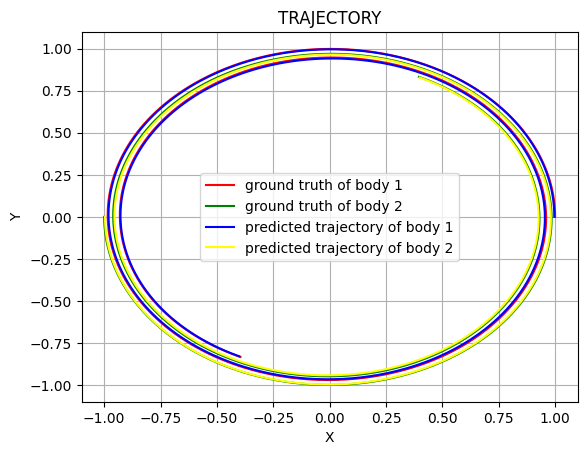

In [45]:
pred_traj=model(t_tensor).detach().numpy()
ground_truth=pos_true.detach().numpy()
plt.plot(ground_truth[:,0],ground_truth[:,1],color='red',label='ground truth of body 1')
plt.plot(ground_truth[:,2],ground_truth[:,3],'green',label='ground truth of body 2')
plt.plot(pred_traj[:,0],pred_traj[:,1],'blue',label='predicted trajectory of body 1')
plt.plot(pred_traj[:,2],pred_traj[:,3],'yellow',label='predicted trajectory of body 2')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title("TRAJECTORY")
plt.grid(True)
plt.show()